# Pandas

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import warnings
%matplotlib inline

warnings.simplefilter("ignore")

## Read Data

Pandas has the ability to read data from various formats, including:
- CSV
- Excel
- Html
- Json
- Feather
- Parquet

Let's start by reading a table from a csv file. Pandas puts the data in an object known as a `DataFrame`.<br>
The data we are using here is air emissions from industrial facilities in Queensland for the 2005/2006 inventory year taken from [data.gov.au](http://data.gov.au).

In [2]:
!head -n 3 "../../data/processed/Emission/npi-2006-qld-air-total-emissions.csv"

In [3]:
df = pd.read_csv("../../data/processed/Emission/npi-2006-qld-air-total-emissions2.csv", index_col='index')

The `DataFrame` is now stored in variable `df`. We can print it:

In [4]:
df

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q001BOR001-S14,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Arsenic & compounds,Air Total,6.31,S14
Q001BOR001-S0,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Beryllium & compounds,Air Total,0.52,S0
Q001BOR001-S69,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Cadmium & compounds,Air Total,2.12,S69
Q001BOR001-S1,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Carbon monoxide,Air Total,170743.00,S1
Q001BOR001-S52,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Chromium (III) compounds,Air Total,18.80,S52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q086ILE042-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE042,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.374167,152.463889,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,13450.00,S53
Q086ILE043-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE043,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.384722,152.470556,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,17754.00,S53
Q086ILE044-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE044,PAUL & CHARMAINE SCALIA,Scalia,...,4341,-27.622222,152.470833,Meat Chicken Facility,172,Poultry Farming (Eggs),Ammonia (total),Air Total,13610.00,S53


Similarly, using the respective read method you can read the tables from other file formats supported by Pandas. <br>
e.g. `pd.read_excel()` 

Pandas can also read the data from SQL database and put them directly into a pandas data frame. To do that, we need to pass in the query and the connection object.

In [5]:
import sqlite3

# create a connection to database
conn = sqlite3.connect("../b01_SQL/Sales.db")

# write a query
query = """
SELECT * from Customers
LIMIT 5
"""

pd.read_sql(query, conn)

,CustomerID,Title,Firstname,Surname,PhoneNumber,Mobile,Fax,Email,Address,City,Country,CreditCardNumber,CreditCardExpiry,SignupDate
0,1,Mr.,Jorge,Dunn,None,0429937146,48585127,sbrooks@hotmail.com,99098 Rachael Cliff,New Jasonborough,Poland,341571816096695,12/20,2019-06-17
1,2,Mrs.,Debra,Wall,56978970,0470205559,None,colleenalexander@taylor-brown.net,9716 Andrea Place Apt. 808,Harrisberg,Portugal,4846279439697392,02/24,2015-01-02
2,3,Dr.,Cynthia,Ellis,None,0469055029,82096582,vstewart@gmail.com,21014 Jared Mount,Lopezmouth,Germany,213179187652107,01/30,2014-07-21
3,4,Mr.,John,Harris,None,0475137980,None,yarmstrong@hotmail.com,54725 Todd Corners,New Timothy,Bahrain,3567765520251007,02/22,2011-07-26
4,5,Mr.,Kyle,Jones,21424091,0404892875,24628569,cindy97@yahoo.com,97603 Joseph Terrace Apt. 079,Sherryland,Hong Kong,4290875996151482,07/29,2013-09-26


__Tip:__ Sometimes you just want to quickly copy a portion of a dataset from a webpage or excel into a notebook. An easy way to do that is to copy the data from the source and then use `pd.read_clipboard()`. This method will create a pandas data frame from the data you copied. Note that this method only works if the notebook is running on your local machine (not on an external server).

## Basic Analysis
- info
- describe
- pandas profiling
- value_counts()


In [6]:
df = pd.read_csv("../../data/processed/Emission/npi-2006-qld-air-total-emissions2.csv", index_col='index')
df

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q001BOR001-S14,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Arsenic & compounds,Air Total,6.31,S14
Q001BOR001-S0,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Beryllium & compounds,Air Total,0.52,S0
Q001BOR001-S69,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Cadmium & compounds,Air Total,2.12,S69
Q001BOR001-S1,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Carbon monoxide,Air Total,170743.00,S1
Q001BOR001-S52,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Chromium (III) compounds,Air Total,18.80,S52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q086ILE042-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE042,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.374167,152.463889,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,13450.00,S53
Q086ILE043-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE043,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.384722,152.470556,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,17754.00,S53
Q086ILE044-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE044,PAUL & CHARMAINE SCALIA,Scalia,...,4341,-27.622222,152.470833,Meat Chicken Facility,172,Poultry Farming (Eggs),Ammonia (total),Air Total,13610.00,S53


We can use `.head()` and `.tail()` to view only top or bottom rows of the table.

In [7]:
# top rows
df.head()

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q001BOR001-S14,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Arsenic & compounds,Air Total,6.31,S14
Q001BOR001-S0,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Beryllium & compounds,Air Total,0.52,S0
Q001BOR001-S69,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Cadmium & compounds,Air Total,2.12,S69
Q001BOR001-S1,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Carbon monoxide,Air Total,170743.00,S1
Q001BOR001-S52,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Chromium (III) compounds,Air Total,18.80,S52


In [8]:
# bottom rows
df.tail()

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q086ILE042-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE042,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.374167,152.463889,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,13450.0,S53
Q086ILE043-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE043,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.384722,152.470556,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,17754.0,S53
Q086ILE044-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE044,PAUL & CHARMAINE SCALIA,Scalia,...,4341,-27.622222,152.470833,Meat Chicken Facility,172,Poultry Farming (Eggs),Ammonia (total),Air Total,13610.0,S53
Q086ILE045-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE045,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4343,-27.458349,152.367415,Poultry - fertile Eggs,172,Poultry Farming (Eggs),Ammonia (total),Air Total,34205.0,S53
Q086SLI001-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086SLI001,SLALOM INVESTMENTS PTY LTD,SLALOM INVESTMENTS PTY LTD,...,4356,-27.759444,151.539444,Egg Production,172,Poultry Farming (Eggs),Ammonia (total),Air Total,11362.0,S53


__Note:__ You can specify how many rows from the top or bottom of the table you want by passing in a number.<br>
e.g. `df.head(10)` or `df.tail(3)`

We can use `.columns` to get a list of column names.

In [9]:
df.columns

Index(['jurisdiction', 'Year', 'data_start_date', 'data_end_date',
       'first_published_date', 'last_updated_date', 'sub_threshold',
       'jurisdiction_facility_id', 'registered_business_name', 'facility_name',
       'site_address_street', 'site_address_suburb', 'site_address_state',
       'site_address_postcode', 'site_latitude', 'site_longitude',
       'main_activities', 'ANZSIC code', 'ANZSIC name', 'substance',
       'destination', 'quantity_in_kg', 'substance_code'],
      dtype='object')

Using `.info()` method you can get a list of the columns and the type of data stored in each.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9375 entries, Q001BOR001-S14 to Q086SLI001-S53
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   jurisdiction              9375 non-null   object 
 1   Year                      9375 non-null   int64  
 2   data_start_date           9375 non-null   object 
 3   data_end_date             9375 non-null   object 
 4   first_published_date      9375 non-null   object 
 5   last_updated_date         9375 non-null   object 
 6   sub_threshold             9375 non-null   object 
 7   jurisdiction_facility_id  9375 non-null   object 
 8   registered_business_name  9375 non-null   object 
 9   facility_name             9375 non-null   object 
 10  site_address_street       9375 non-null   object 
 11  site_address_suburb       9375 non-null   object 
 12  site_address_state        9375 non-null   object 
 13  site_address_postcode     9375 non-null   int

You can also get some basic statistical analysis of the data using `.describe()` method.

In [11]:
df.describe()

,Year,site_address_postcode,site_latitude,site_longitude,ANZSIC code,quantity_in_kg
count,9375.0,9375.000000,9375.000000,9375.000000,9375.000000,9.375000e+03
mean,2006.0,4541.100373,-24.034062,149.625650,1987.567893,1.205184e+05
std,0.0,267.957741,4.200536,3.838858,1237.421112,2.803064e+06
min,2006.0,4006.000000,-28.913000,138.123778,143.000000,0.000000e+00
25%,2006.0,4340.000000,-27.466667,147.867500,1111.000000,2.600000e-01
50%,2006.0,4650.000000,-25.395083,151.120704,1841.000000,1.210000e+01
75%,2006.0,4742.000000,-21.762662,152.928364,2921.000000,7.310000e+02
max,2006.0,4895.000000,-9.232500,153.512054,9531.000000,2.385545e+08


To get a more detailed analysis of the data in the table we can use a package called `pandas-profiling`. This package extends Pandas and adds detailed reports of the data.

<a href="./profile_qld-air-emissions.html">If you get an error use this pre-made report</a>


In [12]:
# profile = pp.ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("profile_qld-air-emissions.html")
# profile

## Subsetting and indexing

There are multiple ways to get a subset of the data. `loc` is used when we want to specify the names of columns and `iloc` when we want to use the index of the columns.<br>


We can use `loc` by specifying the rows and columns we want by name. e.g. `df.loc[{row(s)}, {column(s) name}]`

we can get a subset of a single column:

In [13]:
df.loc[:'Q001BOR001-S52', "jurisdiction"]

# Notice we used :NAME for rows which means give me the rows up to NAME

index
Q001BOR001-S14    QLD
Q001BOR001-S0     QLD
Q001BOR001-S69    QLD
Q001BOR001-S1     QLD
Q001BOR001-S52    QLD
Name: jurisdiction, dtype: object

__Note:__ `loc` has a unique property. Since it is designed to work with names of columns and rows, when you want to get a subset of rows, the result it returns is inclusive. In other words when we passed in `:10` in almost every other python object that means `0` to `9`, but in `loc` it means `0` to `10`. Likewise, `10:20` in `loc` means rows `10` to `20`.

We can also get a subset of multiple columns by passing a list of columns we want.

In [14]:
df.loc['Q001BOR001-S14':'Q001BOR001-S52', ["Year", "facility_name", "substance", "quantity_in_kg"]]

,Year,facility_name,substance,quantity_in_kg
index,,,,
Q001BOR001-S14,2006,DARRA,Arsenic & compounds,6.31
Q001BOR001-S0,2006,DARRA,Beryllium & compounds,0.52
Q001BOR001-S69,2006,DARRA,Cadmium & compounds,2.12
Q001BOR001-S1,2006,DARRA,Carbon monoxide,170743.00
Q001BOR001-S52,2006,DARRA,Chromium (III) compounds,18.80


`iloc` works similar to `loc`, but instead of names we pass in index of the rows or the columns we want.

In [15]:
# a single column
df.iloc[:10, 5]

index
Q001BOR001-S14    31/03/2010
Q001BOR001-S0     31/03/2010
Q001BOR001-S69    31/03/2010
Q001BOR001-S1     31/03/2010
Q001BOR001-S52    31/03/2010
Q001BOR001-S49    31/03/2010
Q001BOR001-S36    31/03/2010
Q001BOR001-S27    31/03/2010
Q001BOR001-S5     31/03/2010
Q001BOR001-S23    31/03/2010
Name: last_updated_date, dtype: object

__Note:__ Notice the number of rows here, and compare it with when we used `loc`.

In [16]:
# You can see the number corresponding to a column name here
list(enumerate(df.columns))

[(0, 'jurisdiction'),
 (1, 'Year'),
 (2, 'data_start_date'),
 (3, 'data_end_date'),
 (4, 'first_published_date'),
 (5, 'last_updated_date'),
 (6, 'sub_threshold'),
 (7, 'jurisdiction_facility_id'),
 (8, 'registered_business_name'),
 (9, 'facility_name'),
 (10, 'site_address_street'),
 (11, 'site_address_suburb'),
 (12, 'site_address_state'),
 (13, 'site_address_postcode'),
 (14, 'site_latitude'),
 (15, 'site_longitude'),
 (16, 'main_activities'),
 (17, 'ANZSIC code'),
 (18, 'ANZSIC name'),
 (19, 'substance'),
 (20, 'destination'),
 (21, 'quantity_in_kg'),
 (22, 'substance_code')]

In [17]:
# multiple columns
df.iloc[10:20, [1, 9, -3, -1]]

,Year,facility_name,destination,substance_code
index,,,,
Q001BOR001-S45,2006,DARRA,Air Total,S45
Q001BOR001-S29,2006,DARRA,Air Total,S29
Q001BOR001-S8,2006,DARRA,Air Total,S8
Q001BOR001-S12,2006,DARRA,Air Total,S12
Q001BOR001-S46,2006,DARRA,Air Total,S46
Q001BOR001-S55,2006,DARRA,Air Total,S55
Q001BOR001-S72,2006,DARRA,Air Total,S72
Q001BOR001-S40,2006,DARRA,Air Total,S40
Q001BOR001-S6,2006,DARRA,Air Total,S6


Another useful method to get a subset of data is using boolean indexing. Booleans are either True or False. If we pass a list of booleans, pandas will return only the rows with True in the list.

In [18]:
mask = df["substance"] == "Oxides of Nitrogen"
mask

index
Q001BOR001-S14    False
Q001BOR001-S0     False
Q001BOR001-S69    False
Q001BOR001-S1     False
Q001BOR001-S52    False
                  ...  
Q086ILE042-S53    False
Q086ILE043-S53    False
Q086ILE044-S53    False
Q086ILE045-S53    False
Q086SLI001-S53    False
Name: substance, Length: 9375, dtype: bool

The list above has the value true only on the rows where the substance is "Oxides of Nitrogen". <br>
__Note:__ you can only see a small portion of the data so the True values might not be visible.

Now if we pass this as an index into a data frame we only get the rows where substance is "Oxides of Nitrogen".

In [19]:
df[mask]

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q001BOR001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Oxides of Nitrogen,Air Total,108967.0,S72
Q001CPL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001CPL001,CLAYPAVE PTY LTD,CLAYPAVE PTY LTD,...,4303,-27.605638,152.832185,"Manufacture of clay pavers, bricks and refract...",2021,Clay Brick Manufacturing,Oxides of Nitrogen,Air Total,17900.0,S72
Q001PGH001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001PGH001,CSR BUILDING PRODUCTS LTD,PGH Bricks & Pavers,...,4500,-27.317025,152.996906,Manufacture of Clay Brick and Pavers,2021,Clay Brick Manufacturing,Oxides of Nitrogen,Air Total,12792.0,S72
Q001PGH002-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001PGH002,CSR BUILDING PRODUCTS LTD,PGH Bricks and Pavers,...,4563,-26.392025,152.925239,"Manufacture of clay bricks, blocks and pavers",2021,Clay Brick Manufacturing,Oxides of Nitrogen,Air Total,17682.0,S72
Q001PGH003-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001PGH003,CSR BUILDING PRODUCTS LTD,PGH Bricks and Pavers,...,4077,-27.572250,152.969800,Manufacture of clay bricks,2021,Clay Brick Manufacturing,Oxides of Nitrogen,Air Total,2613.0,S72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q080QBH001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q080QBH001,QUEENSLAND BULK HANDLING PTY LTD,QUEENSLAND BULK HANDLING PTY LTD,...,4178,-27.388333,153.162222,"Coal unloading, stockpiling and loading to shi...",5212,Port and Water Transport Terminal Operations,Oxides of Nitrogen,Air Total,11651.0,S72
Q082BOR001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q082BOR001,BORAL AUST GYPSUM LTD,Boral Plasterboard Northgate,...,4013,-27.392803,153.071054,Manufacture of plasterboard and plaster,2032,Plaster Product Manufacturing,Oxides of Nitrogen,Air Total,28841.0,S72
Q085CRL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q085CRL001,CONSOLIDATED RUTILE LTD,Pinkenba Processing Plant,...,4008,-27.436507,153.103643,Rutile sand mining,805,Mineral Sand Mining,Oxides of Nitrogen,Air Total,10286.0,S72


This method can also be used with `loc` and `iloc`.

In [20]:
df.loc[
    df["substance"] == "Oxides of Nitrogen",
    ["facility_name", "substance", "quantity_in_kg"],
]

,facility_name,substance,quantity_in_kg
index,,,
Q001BOR001-S72,DARRA,Oxides of Nitrogen,108967.0
Q001CPL001-S72,CLAYPAVE PTY LTD,Oxides of Nitrogen,17900.0
Q001PGH001-S72,PGH Bricks & Pavers,Oxides of Nitrogen,12792.0
Q001PGH002-S72,PGH Bricks and Pavers,Oxides of Nitrogen,17682.0
Q001PGH003-S72,PGH Bricks and Pavers,Oxides of Nitrogen,2613.0
...,...,...,...
Q080QBH001-S72,QUEENSLAND BULK HANDLING PTY LTD,Oxides of Nitrogen,11651.0
Q082BOR001-S72,Boral Plasterboard Northgate,Oxides of Nitrogen,28841.0
Q085CRL001-S72,Pinkenba Processing Plant,Oxides of Nitrogen,10286.0


## Sorting
To sort the data in the table based on a certain column we can use the `.sort_values` method. When sorting we need to specify which column we want to sort and whether we want to sort in ascending order or descending order.

In [21]:
df2 = df.sort_values(by="jurisdiction_facility_id", ascending=False)
df2

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q086SLI001-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086SLI001,SLALOM INVESTMENTS PTY LTD,SLALOM INVESTMENTS PTY LTD,...,4356,-27.759444,151.539444,Egg Production,172,Poultry Farming (Eggs),Ammonia (total),Air Total,11362.00,S53
Q086ILE045-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE045,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4343,-27.458349,152.367415,Poultry - fertile Eggs,172,Poultry Farming (Eggs),Ammonia (total),Air Total,34205.00,S53
Q086ILE044-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE044,PAUL & CHARMAINE SCALIA,Scalia,...,4341,-27.622222,152.470833,Meat Chicken Facility,172,Poultry Farming (Eggs),Ammonia (total),Air Total,13610.00,S53
Q086ILE043-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE043,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.384722,152.470556,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,17754.00,S53
Q086ILE042-S53,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q086ILE042,BARTTER ENTERPRISES PTY LTD,BARTTER ENTERPRISES PTY LTD,...,4311,-27.374167,152.463889,Meat Breeder Rearing Facility,171,Poultry Farming (Meat),Ammonia (total),Air Total,13450.00,S53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q001BOR001-S6,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Polychlorinated dioxins and furans (TEQ),Air Total,0.00,S6
Q001BOR001-S60,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Polycyclic aromatic hydrocarbons (B[a]Peq),Air Total,0.00,S60
Q001BOR001-S2,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q001BOR001,BORAL BRICKS P/L,DARRA,...,4076,-27.565416,152.958722,Manufacture and sale of clay bricks and pavers,2021,Clay Brick Manufacturing,Sulfur dioxide,Air Total,109293.00,S2


__Note:__ many methods return the result as a data frame as well. This allows us to chain these operations to make the code shorter and easier to read.<br>
 

Let's sort the table based on the amount of Oxides of Nitrogen only.

In [22]:
df.loc[df["substance"] == "Oxides of Nitrogen"].sort_values(
    by="quantity_in_kg", ascending=False
)

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q019TAR001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019TAR001,TARONG ENERGY CORP LTD,Tarong Power Station,...,4615,-26.786480,151.914128,Electricity generation using coal or coal deri...,2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,48428084.0,S72
Q019NRG001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019NRG001,NRG GLADSTONE OPERATING SERVICES P/L,Gladstone Power Station,...,4680,-23.856484,151.218582,Electricity generation using coal or coal deri...,2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,41248832.0,S72
Q019SCL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019SCL001,STANWELL CORP LTD,Stanwell Power Station,...,4702,-23.508888,150.317777,Combustion of fossil fuels to produce electricity,2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,37912188.0,S72
Q019CSE001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019CSE001,CS ENERGY LTD,Callide Power Station (A & B),...,4715,-24.345000,150.618900,Combustion of fossil fuels to produce electricity,2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,19416120.0,S72
Q019MIL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019MIL001,MILLMERRAN OPERATING CO P/L,Millmerran Power,...,4357,-27.962800,151.278200,Power Generation from Fossil fuel combustion,2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,12500000.0,S72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q080BHP001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q080BHP001,BHP LTD,Cannington Port Facility,...,4810,-19.253466,146.832201,Storage and Loading of Lead and Zinc Concentrates,5212,Port and Water Transport Terminal Operations,Oxides of Nitrogen,Air Total,110.0,S72
Q031BCC001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q031BCC001,BRISBANE CITY COUNCIL,Eagle Farm Asphalt Plant,...,4009,-27.439268,153.084179,Asphalt Manufacture,1709,Other Petroleum and Coal Product Manufacturing,Oxides of Nitrogen,Air Total,97.0,S72
Q019ERG037-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q019ERG037,ERGON ENERGY CORP LTD,Dajarra,...,4825,-21.683333,139.500000,"Isolated power station, Diesel Internal Combus...",2611,Fossil Fuel Electricity Generation,Oxides of Nitrogen,Air Total,86.6,S72


We can also sort based on multiple columns. To do so we need to pass in the name of the column in a list (in the order we want them to be used for sorting) and also a list to specify whether each column should be ascending or descending.

In [23]:
df.loc[df["substance"] == "Oxides of Nitrogen"].sort_values(
    by=["site_address_postcode", "facility_name"], ascending=[True, False]
)

,jurisdiction,Year,data_start_date,data_end_date,first_published_date,last_updated_date,sub_threshold,jurisdiction_facility_id,registered_business_name,facility_name,...,site_address_postcode,site_latitude,site_longitude,main_activities,ANZSIC code,ANZSIC name,substance,destination,quantity_in_kg,substance_code
index,,,,,,,,,,,,,,,,,,,,,
Q031BOR002-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q031BOR002,BORAL RESOURCES (QLD) P/L,Boral Asphalt,...,4007,-27.438436,153.078419,Asphalt Manufacturing,1709,Other Petroleum and Coal Product Manufacturing,Oxides of Nitrogen,Air Total,9823.0,S72
Q022SHE017-S72,QLD,2006,1/01/2005,31/12/2005,31/01/2007,31/03/2010,N,Q022SHE017,THE SHELL CO OF AUST LTD,PinkenbaTerminal,...,4008,-27.418691,153.128295,Hydrocarbon Storage / Distribution & Bitumen P...,3321,Petroleum Product Wholesaling,Oxides of Nitrogen,Air Total,3504.0,S72
Q085CRL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q085CRL001,CONSOLIDATED RUTILE LTD,Pinkenba Processing Plant,...,4008,-27.436507,153.103643,Rutile sand mining,805,Mineral Sand Mining,Oxides of Nitrogen,Air Total,10286.0,S72
Q023BCC004-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q023BCC004,BRISBANE CITY COUNCIL - BRISBANE WATER,Luggage Point WWTP,...,4008,-27.380596,153.150174,Sewerage and Wastewater Treatment,2812,Sewerage and Drainage Services,Oxides of Nitrogen,Air Total,5100.0,S72
Q040IGC001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q040IGC001,INDUSTRIAL GALVANIZERS CORP P/L,Industrial Galvanizers Brisbane,...,4008,-27.438421,153.101186,Hot Dip Galvanizing of Steel,2293,Metal Coating and Finishing,Oxides of Nitrogen,Air Total,2525.0,S72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q028CLT001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q028CLT001,NERADA TEA ESTATES PTY LTD,Glen Allyn Tea Estate,...,4885,-17.383500,145.667000,Nerada grows tea and processes the G/Leaf in t...,1199,Other Food Product Manufacturing n.e.c.,Oxides of Nitrogen,Air Total,9672.0,S72
Q026MDL001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q026MDL001,MALANDA DAIRYFOODS LTD,Dairy Farmers Malanda,...,4885,-17.351912,145.595819,Milk Processing,1131,Milk and Cream Processing,Oxides of Nitrogen,Air Total,4063.0,S72
Q080PAS001-S72,QLD,2006,1/07/2005,30/06/2006,31/01/2007,31/03/2010,N,Q080PAS001,ZINIFEX CENTURY LTD,Zinifex Century Mine- Karumba Port,...,4891,-17.498056,140.836944,Filtering and Drying of lead and zinc concentr...,807,Silver-Lead-Zinc Ore Mining,Oxides of Nitrogen,Air Total,19871.0,S72


## Data operations
-merge
-groupby
-pivot_table
-crosstab

__Groupby:__ It aggregates the data into groups (similar to groupby in SQL). For instance, what if we wanted an average emission of each substance across all the sites? To calculate that we use `.groupby()` method.

Since we want the average amount of substances, the columns we need will be __substance__ and __quantity_in_kg__.

In [24]:
groups = df[["substance", "quantity_in_kg"]].groupby(by="substance")
groups

In [25]:
name, group = list(groups)[0]
print(name)
group

1,1,1,2-Tetrachloroethane


,substance,quantity_in_kg
index,,
Q001PGH001-S48,"1,1,1,2-Tetrachloroethane",0.0724
Q001PGH002-S48,"1,1,1,2-Tetrachloroethane",0.0966
Q001PGH003-S48,"1,1,1,2-Tetrachloroethane",0.1700
Q020BHP002-S48,"1,1,1,2-Tetrachloroethane",0.0000
Q080BHP001-S48,"1,1,1,2-Tetrachloroethane",0.0000


But it doesn't show us any tables. The reason is pandas has grouped the data into `DataFrameGroupBy` object and now we need to specify how the values should be aggregated. In this case since we want the average we use `.mean()`.

In [26]:
df[["substance", "quantity_in_kg"]].groupby(by="substance").mean()

,quantity_in_kg
substance,
"1,1,1,2-Tetrachloroethane",0.067800
"1,1,2-Trichloroethane",1.028285
"1,2-Dibromoethane",50.000000
"1,2-Dichloroethane",3.100041
"1,3-Butadiene (vinyl ethylene)",1.802580
...,...
Trichloroethylene,5584.750000
Vinyl Chloride Monomer,34.237040
Xylenes (individual or mixed isomers),715.616385


There are other useful aggregation functions such as `.std()` for standard deviation, `.median()` for median, `.count()` for the number of rows in each group, `.sum()` for sum, etc. You can also define your own aggregation function.

In [27]:
agg_func = lambda x: np.sqrt((x ** 2).mean())  # root mean of squares
df[["substance", "quantity_in_kg"]].groupby(by="substance").apply(agg_func)

,quantity_in_kg
substance,
"1,1,1,2-Tetrachloroethane",0.093245
"1,1,2-Trichloroethane",2.589484
"1,2-Dibromoethane",50.000000
"1,2-Dichloroethane",7.830007
"1,3-Butadiene (vinyl ethylene)",8.022719
...,...
Trichloroethylene,11159.504480
Vinyl Chloride Monomer,87.487409
Xylenes (individual or mixed isomers),5012.507739


<font color='green'>Do you know how to use *__lambda__* functions? If not check out <a href = 'https://www.w3schools.com/python/python_lambda.asp'>this page</a> to learn about them.</font>

### Pivot Table
Another way to represent the data is using pivot tables. You might be familiar with pivot tables in Excel. You can perform the same operations here as well.

Let's create a pivot table that shows the amount of each substance in every postcode in the dataset.

In [28]:
df.pivot_table(
    index="site_address_postcode",
    columns="substance",
    values="quantity_in_kg",
    aggfunc="mean",
)

substance,"1,1,1,2-Tetrachloroethane","1,1,2-Trichloroethane","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene (vinyl ethylene)",Acetaldehyde,Acetic acid (ethanoic acid),Acetone,Acetonitrile,Acrylamide,...,Sulfuric acid,Tetrachloroethylene,Toluene (methylbenzene),"Toluene-2,4-diisocyanate",Total Volatile Organic Compounds,Trichloroethylene,Vinyl Chloride Monomer,Xylenes (individual or mixed isomers),Zinc and compounds,n-Hexane
site_address_postcode,,,,,,,,,,,,,,,,,,,,,
4006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.765000,NaN,NaN,NaN,NaN,NaN
4007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0014,NaN,1436.000000,NaN,46156.000000,NaN,NaN,753.000,NaN,881.0
4008,NaN,NaN,NaN,NaN,NaN,65.80,NaN,NaN,NaN,NaN,...,520.0000,NaN,30384.966667,NaN,502521.650000,NaN,NaN,20189.075,87.2,46679.7
4009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3158.750000,NaN,89518.775000,NaN,NaN,873.650,NaN,4200.0
4013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3209.000000,NaN,NaN,NaN,95.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,409.000000,NaN,NaN,NaN,NaN,NaN
4885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,347.500000,NaN,NaN,NaN,NaN,NaN
4890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,191.000000,NaN,NaN,1.020,NaN,NaN


__Note:__ `NaN` stands for Not a Number. In this case it means there was no value available for that cell. This means where you see `NaN` in the table there was no emission recorded for that substance in that specific postcode. This probably means that we can assume the emission was zero. We could let pandas know by passing in `fill_value = 0`. Then, where no value is available pandas put zero instead.


In [29]:
df.pivot_table(
    index="site_address_postcode",
    columns="substance",
    values="quantity_in_kg",
    aggfunc="mean",
    fill_value=0,
)

substance,"1,1,1,2-Tetrachloroethane","1,1,2-Trichloroethane","1,2-Dibromoethane","1,2-Dichloroethane","1,3-Butadiene (vinyl ethylene)",Acetaldehyde,Acetic acid (ethanoic acid),Acetone,Acetonitrile,Acrylamide,...,Sulfuric acid,Tetrachloroethylene,Toluene (methylbenzene),"Toluene-2,4-diisocyanate",Total Volatile Organic Compounds,Trichloroethylene,Vinyl Chloride Monomer,Xylenes (individual or mixed isomers),Zinc and compounds,n-Hexane
site_address_postcode,,,,,,,,,,,,,,,,,,,,,
4006,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,0.000000,0.0,11.765000,0,0.0,0.000,0.0,0.0
4007,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0014,0.0,1436.000000,0.0,46156.000000,0,0.0,753.000,0.0,881.0
4008,0.0,0.0,0,0.0,0.00,65.80,0.0,0.0,0,0.0,...,520.0000,0.0,30384.966667,0.0,502521.650000,0,0.0,20189.075,87.2,46679.7
4009,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,3158.750000,0.0,89518.775000,0,0.0,873.650,0.0,4200.0
4013,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,0.000000,0.0,3209.000000,0,0.0,0.000,95.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,0.000000,0.0,409.000000,0,0.0,0.000,0.0,0.0
4885,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,0.000000,0.0,347.500000,0,0.0,0.000,0.0,0.0
4890,0.0,0.0,0,0.0,0.00,0.00,0.0,0.0,0,0.0,...,0.0000,0.0,0.000000,0.0,191.000000,0,0.0,1.020,0.0,0.0


 <div class="alert alert-success">
  <h2>Exercise</h2>

Now to practice what we have learned so far, let's create a table of the total emissions (quantity in kg) of the top 10 substances (most commonly recorded substances in the dataset) for each postcode.<br>
    
1. Find how many times each substance occurs `substance_count`
2. Sort `substance_count` and find 10 most common substance `top10`
3. Create a seperate dataframe that shows the total weight of each substance per postcode `weight_by_postcode`
4. Combine `weight_by_postcode` and `top10` to get the weight by postcode of the top 10 substances 
    
```python
# 1. Find how many times each substance has been recorded (this has been done for you)
# substance_count = df[["site_address_postcode", "substance"]].??

# 2. Sort it and find the substances that have been recorded the most (this has been done for you)
# top10 = substance_count.??

# 3. Create a seperate table that shows the total weight of each substance per postcode (hint: pivot table or groupby)
# pivot = ??

# 4. Combine the tables, to get a subset which only includes the top 10 substances
# pivot_top10 = ??
```
      

  <details>
  <summary><b>→ Hints</b></summary>

1. use groupby then count
2. use .sort_values() then get the first 10 rows
3. A pivot table will do this easily
4. `weight_by_postcode[top10.index]`

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

```python
# you can replace site_address_postcode by any other column. Since we are only counting it doesn't matter which column use.
substance_count = df[["site_address_postcode", "substance"]].groupby(by="substance").count()

# Now sort it, and take the first 10 results
substance_count.columns = ["Count"] # rename column
top10 = substance_count.sort_values(by="Count", ascending=False)[:10]

# Create the pivot table
pivot = df.pivot_table(
    index="site_address_postcode",
    columns="substance",
    values="quantity_in_kg",
    aggfunc="sum",
)

# get only the columns for top 10 substances
pivot_top10 = pivot[top10.index]
pivot_top10
```

  </details>

  </div>

Now it's a good time to discuss dealing with missing values in a table.

## Missing Values
There might be missing data in a table. Having `NaN` in the table can cause trouble in the analysis so we need to decide how we are going to deal with it. A few common scenarios are:
1. filling the missing values with a number e.g. zero
2. removing rows with missing values
3. removeing rows with multiple missing values and filling the remaining with a new value

In [30]:
# you can replace site_address_postcode by any other column. Since we are only counting it doesn't matter which column use.
substance_count = df[["site_address_postcode", "substance"]].groupby(by="substance").count()

# Now sort it, and take the first 10 results
substance_count.columns = ["Count"] # rename column
top10 = substance_count.sort_values(by="Count", ascending=False)[:10]

# Create the pivot table
pivot = df.pivot_table(
    index="site_address_postcode",
    columns="substance",
    values="quantity_in_kg",
    aggfunc="sum",
)

# get only the columns for top 10 substances
pivot_top10 = pivot[top10.index]
pivot_top10

substance,Total Volatile Organic Compounds,Carbon monoxide,Sulfur dioxide,Oxides of Nitrogen,Particulate Matter 10.0 um,Polycyclic aromatic hydrocarbons (B[a]Peq),Xylenes (individual or mixed isomers),Toluene (methylbenzene),Benzene,Mercury & compounds
site_address_postcode,,,,,,,,,,
4006,23.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4007,138468.00,4092.0,1870.000,9823.0,2572.0,11.7000,753.00,1436.000,378.00,NaN
4008,5025216.50,534408.0,2316025.600,681944.0,249500.1,13.7888,80756.30,91154.900,37018.40,13.0244
4009,358075.10,6864.0,4.001,862.0,322.2,21.9050,1747.30,6317.500,6437.80,NaN
4013,6418.00,199808.0,40916.000,46024.0,27880.0,14.2000,NaN,NaN,NaN,0.6000
...,...,...,...,...,...,...,...,...,...,...
4882,409.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4885,695.00,5205.0,9680.400,13735.0,64444.0,0.0682,NaN,NaN,NaN,NaN
4890,191.00,NaN,NaN,NaN,NaN,NaN,1.02,NaN,NaN,NaN


To replace the missing value with a fixed number we can use `.fillna()` method.

In [31]:
dfnew = pivot_top10.fillna(value=0)
dfnew

substance,Total Volatile Organic Compounds,Carbon monoxide,Sulfur dioxide,Oxides of Nitrogen,Particulate Matter 10.0 um,Polycyclic aromatic hydrocarbons (B[a]Peq),Xylenes (individual or mixed isomers),Toluene (methylbenzene),Benzene,Mercury & compounds
site_address_postcode,,,,,,,,,,
4006,23.53,0.0,0.000,0.0,0.0,0.0000,0.00,0.000,0.00,0.0000
4007,138468.00,4092.0,1870.000,9823.0,2572.0,11.7000,753.00,1436.000,378.00,0.0000
4008,5025216.50,534408.0,2316025.600,681944.0,249500.1,13.7888,80756.30,91154.900,37018.40,13.0244
4009,358075.10,6864.0,4.001,862.0,322.2,21.9050,1747.30,6317.500,6437.80,0.0000
4013,6418.00,199808.0,40916.000,46024.0,27880.0,14.2000,0.00,0.000,0.00,0.6000
...,...,...,...,...,...,...,...,...,...,...
4882,409.00,0.0,0.000,0.0,0.0,0.0000,0.00,0.000,0.00,0.0000
4885,695.00,5205.0,9680.400,13735.0,64444.0,0.0682,0.00,0.000,0.00,0.0000
4890,191.00,0.0,0.000,0.0,0.0,0.0000,1.02,0.000,0.00,0.0000


__Note:__ When using `fillna` the changes are not saved in the data frame. The default settings only returns the result and keeps the original data frame intact. If you want to save the changes in the same data frame you can pass in `inplace = True`.

There are other ways to fill the missing values. In some cases you might want to use different values for each column. A common example is using mean or median of a column for the missing values.

In [32]:
fill_values = pivot_top10.mean()
dfnew = pivot_top10.fillna(value=fill_values)
dfnew

substance,Total Volatile Organic Compounds,Carbon monoxide,Sulfur dioxide,Oxides of Nitrogen,Particulate Matter 10.0 um,Polycyclic aromatic hydrocarbons (B[a]Peq),Xylenes (individual or mixed isomers),Toluene (methylbenzene),Benzene,Mercury & compounds
site_address_postcode,,,,,,,,,,
4006,23.53,793603.077641,2.565225e+06,1.568823e+06,1.112755e+06,274.356493,1664.903427,2376.34755,857.583106,12.48791
4007,138468.00,4092.000000,1.870000e+03,9.823000e+03,2.572000e+03,11.700000,753.000000,1436.00000,378.000000,12.48791
4008,5025216.50,534408.000000,2.316026e+06,6.819440e+05,2.495001e+05,13.788800,80756.300000,91154.90000,37018.400000,13.02440
4009,358075.10,6864.000000,4.001000e+00,8.620000e+02,3.222000e+02,21.905000,1747.300000,6317.50000,6437.800000,12.48791
4013,6418.00,199808.000000,4.091600e+04,4.602400e+04,2.788000e+04,14.200000,1664.903427,2376.34755,857.583106,0.60000
...,...,...,...,...,...,...,...,...,...,...
4882,409.00,793603.077641,2.565225e+06,1.568823e+06,1.112755e+06,274.356493,1664.903427,2376.34755,857.583106,12.48791
4885,695.00,5205.000000,9.680400e+03,1.373500e+04,6.444400e+04,0.068200,1664.903427,2376.34755,857.583106,12.48791
4890,191.00,793603.077641,2.565225e+06,1.568823e+06,1.112755e+06,274.356493,1.020000,2376.34755,857.583106,12.48791


Pandas has other methods for filling the missing values including forward and backward filling. Forward filling replaces the missing values by the last valid value in the table and backward filling replaces the missing values by next valid value. These techniques are useful for sequential data such as time series and wouldn't make sense to be applied to tabular data.<br>
To use these methods, when using `fillna` instead of passing in a value, you can pass a method. For forward filling pass in `method = "ffill"` and for backward filling pass in `method = "bfill"`.

If you simply want to get rid of rows with missing values you can use `.dropna()`

In [33]:
dfnew = pivot_top10.dropna()
dfnew

substance,Total Volatile Organic Compounds,Carbon monoxide,Sulfur dioxide,Oxides of Nitrogen,Particulate Matter 10.0 um,Polycyclic aromatic hydrocarbons (B[a]Peq),Xylenes (individual or mixed isomers),Toluene (methylbenzene),Benzene,Mercury & compounds
site_address_postcode,,,,,,,,,,
4008,5025216.50,534408.000,2316025.6,681944.0,249500.1,13.7888,80756.300,91154.900,37018.400,13.024400
4014,11456.58,15428.000,208.0,4109.0,312.0,0.0300,187.000,527.140,21.790,0.022100
4055,9202.00,8860.000,1909.0,17076.0,22353.0,0.8900,215.700,607.000,25.011,0.013900
4076,76197.00,193463.000,109363.3,115413.0,184617.0,0.1805,304.900,488.700,162.861,1.081300
4077,3714.25,92469.000,47747.0,5643.0,85636.0,0.0150,7.611,97.400,177.000,0.457000
...,...,...,...,...,...,...,...,...,...,...
4871,34075.70,138996.881,23559.0,361559.0,13275.0,14.3900,28.019,63.579,74.559,0.057121
4874,181508.00,1790146.000,985114.0,1321686.0,4323917.0,23.8800,7315.190,4160.230,572.850,3.045000
4875,38340.00,172116.000,225041.0,719426.0,37307.0,32.2500,54.200,83.570,176.170,0.000000


__Note:__ Notice the number of rows are much less in the table above compared to the original table.

If we remove any row that contains missing values we might lose a significant portion of the data. Alternatively, we can only remove rows which have more than a certain number of missing values. To do so, we can set a threshold.

In [34]:
# remove the rows with at least 3 missing values
dfnew = pivot_top10.dropna(thresh=3)
dfnew

substance,Total Volatile Organic Compounds,Carbon monoxide,Sulfur dioxide,Oxides of Nitrogen,Particulate Matter 10.0 um,Polycyclic aromatic hydrocarbons (B[a]Peq),Xylenes (individual or mixed isomers),Toluene (methylbenzene),Benzene,Mercury & compounds
site_address_postcode,,,,,,,,,,
4007,138468.00,4092.0,1870.000,9823.0,2572.0,11.7000,753.00,1436.000,378.00,NaN
4008,5025216.50,534408.0,2316025.600,681944.0,249500.1,13.7888,80756.30,91154.900,37018.40,13.0244
4009,358075.10,6864.0,4.001,862.0,322.2,21.9050,1747.30,6317.500,6437.80,NaN
4013,6418.00,199808.0,40916.000,46024.0,27880.0,14.2000,NaN,NaN,NaN,0.6000
4014,11456.58,15428.0,208.000,4109.0,312.0,0.0300,187.00,527.140,21.79,0.0221
...,...,...,...,...,...,...,...,...,...,...
4876,4583.70,48610.0,2787.000,182636.0,5694.0,9.5800,11.20,16.000,44.40,0.0000
4880,4534.93,466631.0,52845.000,125618.0,33296.0,177.0000,38.70,104.800,58.10,0.0008
4885,695.00,5205.0,9680.400,13735.0,64444.0,0.0682,NaN,NaN,NaN,NaN


Now we have more rows compared to when we removed all missing values.<br>
Next step is to replace the missing values using the techniques discussed above.

## Saving Data
After analysis and reshaping the data you might want to save the results in a file. Similar to reading files, pandas supports multiple file formats to save the tables.

In [35]:
pivot_top10.to_csv("final_table.csv")

## Pandas Plotting
Pandas dataframes have plotting methods which help to visualise the data. The following plots are supported in pandas:
- 'line' : line plot (default)
- 'bar' : vertical bar plot
- 'barh' : horizontal bar plot
- 'hist' : histogram
- 'box' : boxplot
- 'kde' : Kernel Density Estimation plot
- 'density' : same as 'kde'
- 'area' : area plot
- 'pie' : pie plot
- 'scatter' : scatter plot
- 'hexbin' : hexbin plot.

You can select which plot you want to use by setting `kind` to the string for the plot.<br>
There are a few other useful options you can set:
- xlim, ylim: to set limits of axes
- logx, logy, loglog: to set whether an axis should be displayed in logarithmic scale]
- title: to set the title of the plot
- figsize: to set the size of the plot
<br><br>Let's try a few types of charts and graphs.

<AxesSubplot:ylabel='site_address_postcode'>

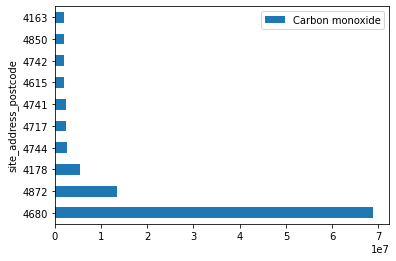

In [36]:
# Top 10 postcodes with largest carbon monoxide emission
pivot_top10.sort_values(by="Carbon monoxide", ascending=False)[:10].plot(
    kind="barh", y="Carbon monoxide"
)

<AxesSubplot:ylabel='Frequency'>

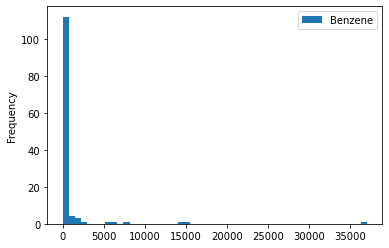

In [37]:
# histogram of benzene emission
pivot_top10.plot(kind="hist", y="Benzene", bins=50)

<AxesSubplot:ylabel='Density'>

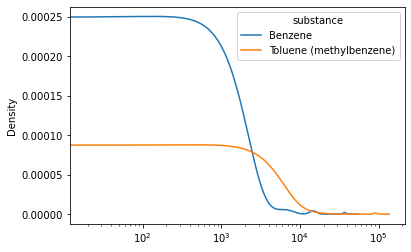

In [38]:
# kernel density estimation plot of benzene emission

pivot_top10.plot(kind="kde", y=["Benzene", "Toluene (methylbenzene)"], logx=True)

<AxesSubplot:>

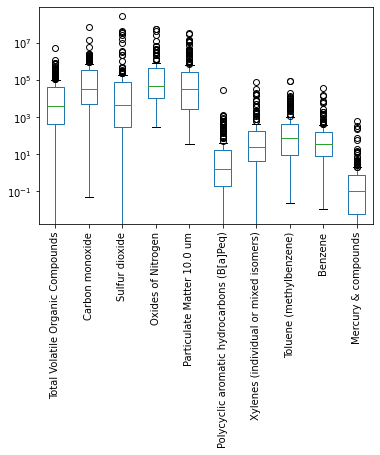

In [39]:
# histogram of benzene emission in each postcode
pivot_top10.plot(kind="box", logy=True, rot=90)

<AxesSubplot:xlabel='Toluene (methylbenzene)', ylabel='Benzene'>

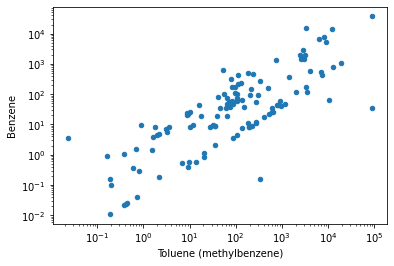

In [40]:
pivot_top10.plot(kind="scatter", x="Toluene (methylbenzene)", y="Benzene", loglog=True)

array([<AxesSubplot:ylabel='4008'>], dtype=object)

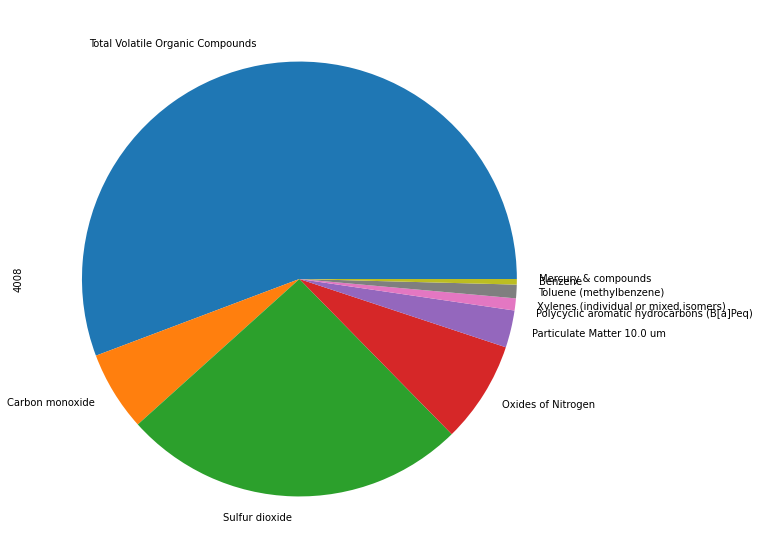

In [41]:
# pie chart of emission of the substances in postcode 4008
pivot_top10.loc[4008, :].plot(kind="pie", subplots=True, figsize=(10, 10))

We will discuss producing more advanced plots in the next notebooks where we learn about various plotting packages in python.

## Further reading
- [Pandas documentation](https://pandas.pydata.org/)
- [Pandas in 10 minutes](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)
- https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
- https://www.kaggle.com/learn/pandas
- https://www.kaggle.com/kashnitsky/topic-1-exploratory-data-analysis-with-pandas
- https://www.youtube.com/watch?v=ZyhVh-qRZPA&list=PL-osiE80TeTsWmV9i9c58mdDCSskIFdDS
